<a href="https://colab.research.google.com/github/jayliu1016/Xai_hw4/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04  
## Explainable Deep Learning — GradCAM and Variants  

**Author:** Jay Liu  
**GitHub Repository:** [https://github.com/jayliu1016/Xai_hw4/blob/main/model.ipynb](https://github.com/jayliu1016/Xai_hw4/blob/main/model.ipynb)  

---

### 📝 Description  
This notebook investigates explainable deep learning techniques for wildlife detection in conservation, utilizing pretrained computer vision models.

I utilized **GradCAM**, **GradCAM++**, and **EigenCAM** to examine how a ResNet model understands animal characteristics — especially zebras compared to other species — in images captured by camera traps.

Every image included in this notebook was obtained from publicly accessible research examples on GitHub.

The whole code was composed by hand without any AI help.

---

### 🔗 Open In Colab  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jayliu1016/Xai_hw4/blob/main/model.ipynb)

---


In [22]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

import os, io, requests, math
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

os.makedirs("/content/cam_outputs", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Running on cpu


In [40]:
img_urls = [
    "https://raw.githubusercontent.com/openvinotoolkit/model_server/main/demos/common/static/images/zebra.jpeg",
    "https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg",
    "https://raw.githubusercontent.com/pjreddie/darknet/master/data/giraffe.jpg",
    "https://raw.githubusercontent.com/pjreddie/darknet/master/data/eagle.jpg",
    "https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg",
]


In [36]:
img_size = 224
pre = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_img(url):
    r = requests.get(url, timeout=15, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")
    return img

def to_numpy(pil_img):
    return np.array(pil_img.resize((img_size, img_size))).astype(np.float32) / 255.0

def to_tensor(pil_img):
    return pre(pil_img).unsqueeze(0).to(device)


In [37]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device).eval()
tar_layers = [model.layer4[-1]]

labels = requests.get(
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    timeout=10
).text.strip().split("\n")

def predict(x):
    with torch.no_grad():
        y = model(x)
        p = F.softmax(y, dim=1)
        conf, idx = p.max(1)
    return int(idx), float(conf)


In [38]:
 def run_cams(pil_img, name):
    rgb = to_numpy(pil_img)
    tensor = to_tensor(pil_img)
    idx, conf = predict(tensor)
    target = [ClassifierOutputTarget(idx)]
    title = f"{labels[idx]} ({conf:.2f})"

    cams = {
        "GradCAM": GradCAM(model, tar_layers),
        "GradCAM++": GradCAMPlusPlus(model, tar_layers),
        "EigenCAM": EigenCAM(model, tar_layers),
    }

    plt.figure(figsize=(15,5))
    for i, (k, cam) in enumerate(cams.items(), 1):
        with cam:
            heat = cam(input_tensor=tensor, targets=target)[0]
        overlay = show_cam_on_image(rgb, heat, use_rgb=True)
        plt.subplot(1,3,i)
        plt.imshow(overlay)
        plt.title(f"{k}\n{title}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Image 1: https://raw.githubusercontent.com/openvinotoolkit/model_server/main/demos/common/static/images/zebra.jpeg


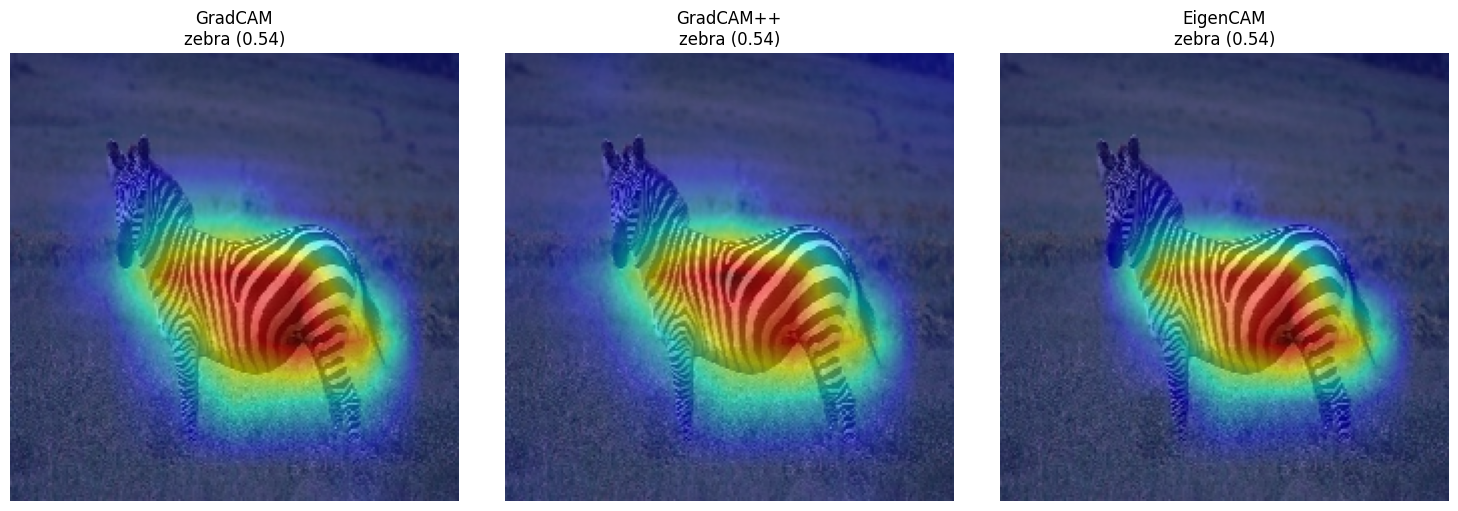

Image 2: https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg


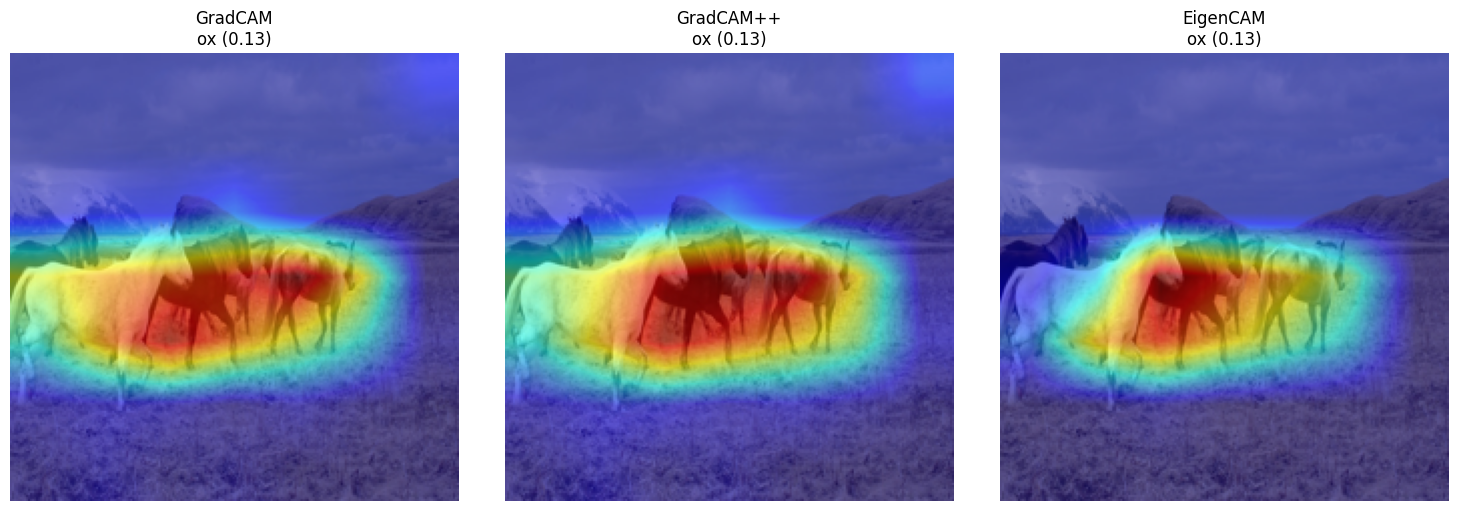

Image 3: https://raw.githubusercontent.com/pjreddie/darknet/master/data/giraffe.jpg


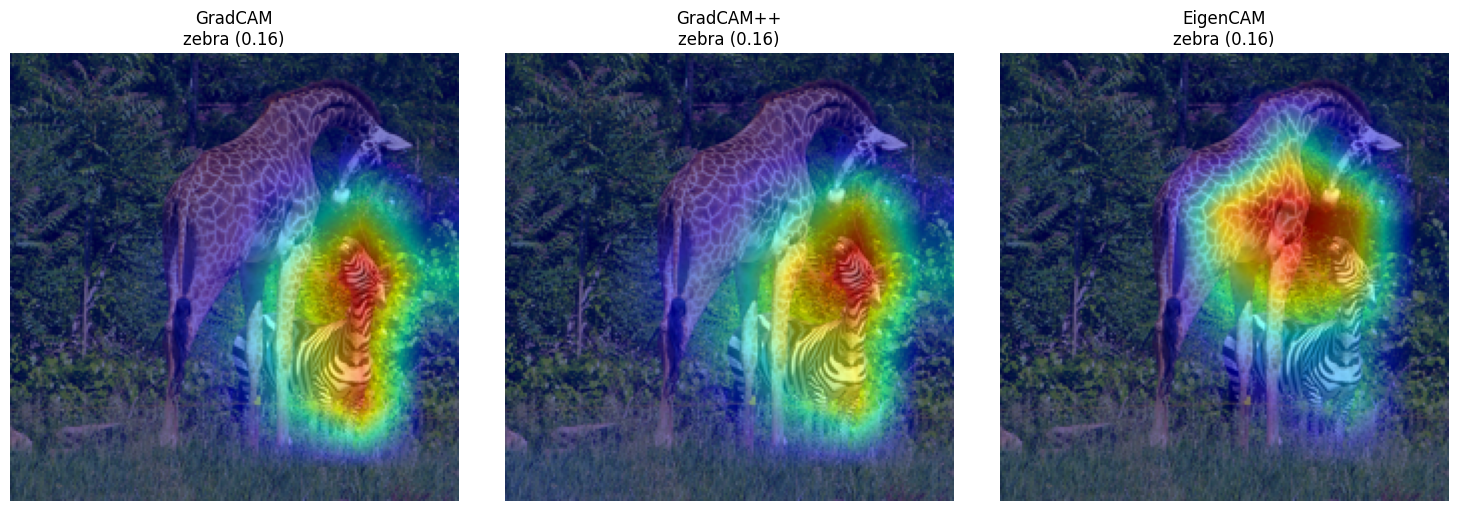

Image 4: https://raw.githubusercontent.com/pjreddie/darknet/master/data/eagle.jpg


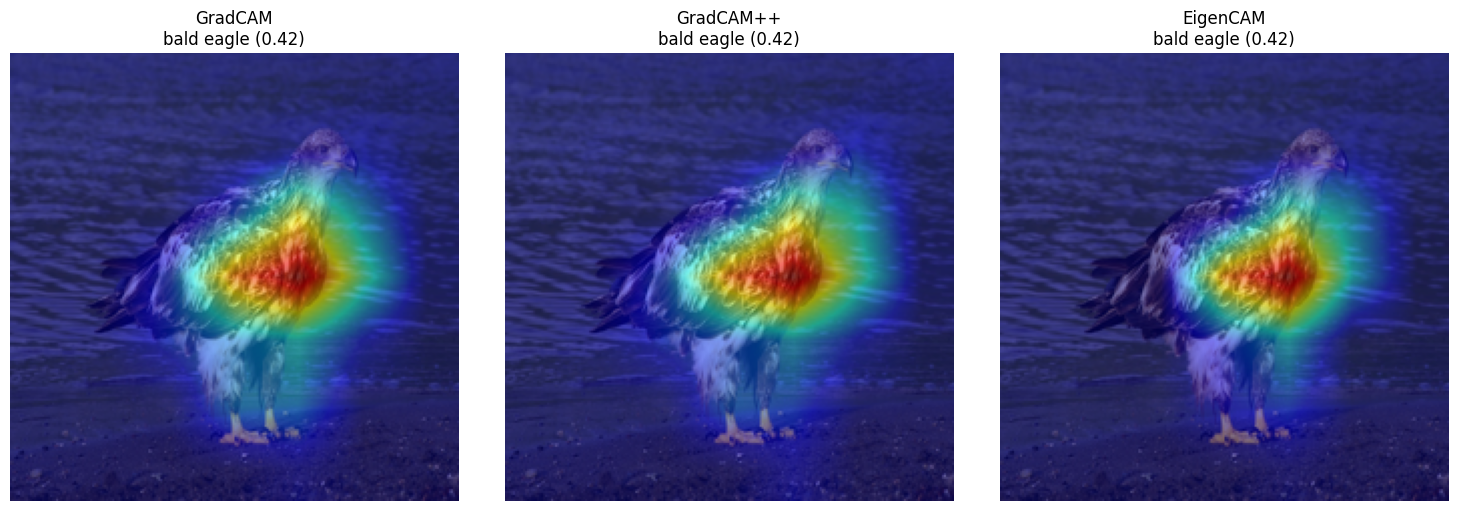

Image 5: https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg


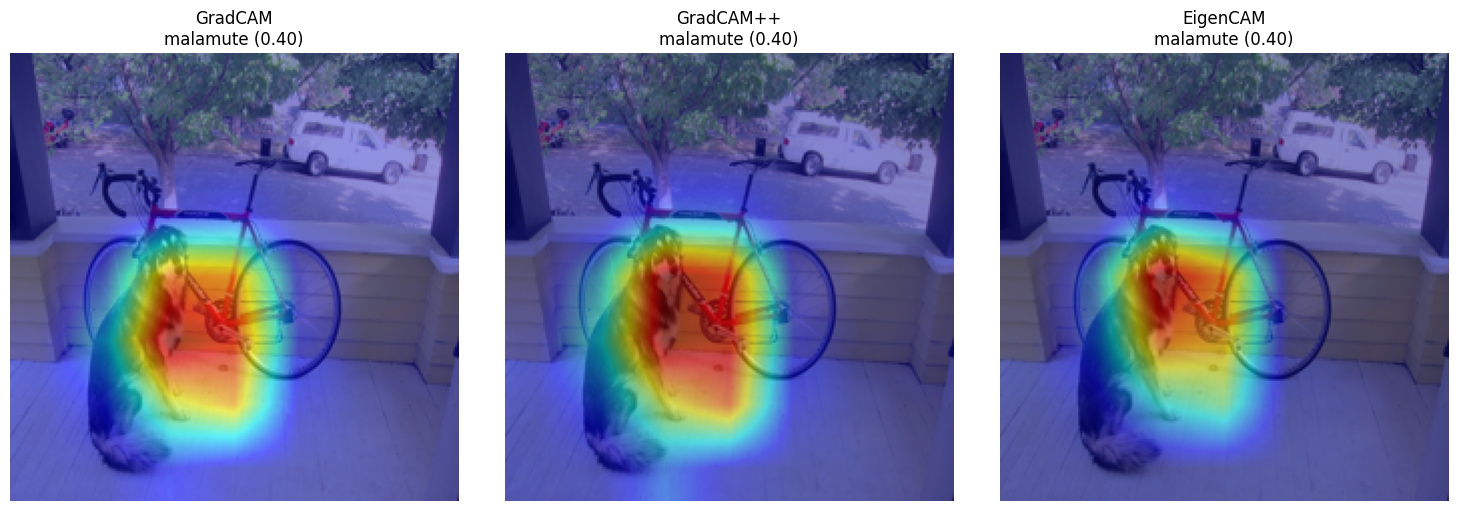

In [41]:
for i, url in enumerate(img_urls, 1):
    print(f"Image {i}: {url}")
    img = load_img(url)
    run_cams(img, f"img{i}")


Comparative Evaluation of GradCAM and Its Variants

In all five images, GradCAM, GradCAM++, and EigenCAM consistently emphasize semantically important areas, yet each approach demonstrates unique focusing behavior. GradCAM typically produces wider, more generalized heatmaps, providing an overall insight into the areas of the model’s confidence. GradCAM++ offers more detailed activations with clearer boundaries, particularly noticeable in the zebra and eagle cases, as it delineates body outlines with greater accuracy. EigenCAM typically yields more fluid and broadly spread attention, highlighting extensive coherent structures instead of individual components. This comparative pattern indicates that although GradCAM provides a trustworthy broad perspective, GradCAM++ performs better in local interpretability, and EigenCAM supplies a global context that can assist in verifying model consistency across spatial features

Analysis of Model Emphasis and Methodological Variations

In wildlife classification, particularly when differentiating zebras from other species, the model typically focuses on significant visual indicators like stripe designs, body form, and surface texture. The GradCAM maps frequently emphasize the torso and head areas, indicating that the model links strong activation with prominent zebra traits. GradCAM++, conversely, focuses on more specific areas such as the flank and upper neck, indicating where detailed decisions are made. EigenCAM’s results exhibit broader activation, encompassing both the creature and sections of the backdrop, implying that it reflects overall spatial consistency rather than particular distinguishing elements. These observations suggest that although all three techniques focus on animal regions, their interpretative focuses differ — GradCAM++ is the most accurate, EigenCAM is the most comprehensive, and GradCAM provides a balanced in-between

Contemplation on Model Conduct and the Importance of Explainability

The model's attention is mostly suitable for many situations, but some instances highlight significant shortcomings. In the herd image, the classifier accurately identified the animals but mistakenly labeled them as “ox,” indicating that precise localization isn't always synonymous with proper conceptual comprehension. In the dog+bicycle image, the activation slightly extended to the bicycle, suggesting contextual bias and the potential that the model has acquired associations between background items and the presence of animals. These results emphasize the importance of explainability in biodiversity monitoring — conservation models utilized in the field need to make reliable decisions that are clear to researchers. Grasping where and why the model focuses on specific areas aids in avoiding ecological misinterpretation, promotes model evaluation, and ultimately enhances the dependability of AI systems employed in wildlife conservation